# Scratch work for TensorFlow skills test (classification)

- Author: Chris Hodapp
- Date: 2017-11-15
- For SharpestMinds/Yazabi

## Links:

- [human-activity-recognition-using-smartphones (GitHub)](https://github.com/pdelboca/human-activity-recognition-using-smartphones)
- [Data source (60 MB ZIP)](https://d396qusza40orc.cloudfront.net/getdata%2Fprojectfiles%2FUCI%20HAR%20Dataset.zip)
- [Human Activity Recognition Using Smartphones (UCI)](http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)
- [MLconf 2015 Seattle: When do I use zero-mean/unit variance normalization vs unit L1/L2 normalization?
](https://www.quora.com/MLconf-2015-Seattle-When-do-I-use-zero-mean-unit-variance-normalization-vs-unit-L1-L2-normalization)

### In TensorFlow section:

- https://www.tensorflow.org/tutorials/layers
- https://www.tensorflow.org/tutorials/linear
- https://www.tensorflow.org/extend/estimators
- https://www.tensorflow.org/programmers_guide/estimators
- http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression
- https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#train
  - This for some reason is completely buried

# Data Exploration

In [200]:
import os

In [201]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sklearn.decomposition
import sklearn.externals
import sklearn.manifold
import sklearn.preprocessing

In [202]:
# I really don't feel like copying these into the document, so
# instead load them from the included file:
feature_list = pd.read_csv("UCI HAR Dataset/features.txt",
    index_col=0, header=None, sep=" ")
# ...and sanitize them so Pandas can use them for column names:
san_dict = {ord("("): "", ord(")"): "", ord("-"): "_", ord(","): "_"}
features = list(f.translate(san_dict) for f in feature_list.iloc[:,0])
features

['tBodyAcc_mean_X',
 'tBodyAcc_mean_Y',
 'tBodyAcc_mean_Z',
 'tBodyAcc_std_X',
 'tBodyAcc_std_Y',
 'tBodyAcc_std_Z',
 'tBodyAcc_mad_X',
 'tBodyAcc_mad_Y',
 'tBodyAcc_mad_Z',
 'tBodyAcc_max_X',
 'tBodyAcc_max_Y',
 'tBodyAcc_max_Z',
 'tBodyAcc_min_X',
 'tBodyAcc_min_Y',
 'tBodyAcc_min_Z',
 'tBodyAcc_sma',
 'tBodyAcc_energy_X',
 'tBodyAcc_energy_Y',
 'tBodyAcc_energy_Z',
 'tBodyAcc_iqr_X',
 'tBodyAcc_iqr_Y',
 'tBodyAcc_iqr_Z',
 'tBodyAcc_entropy_X',
 'tBodyAcc_entropy_Y',
 'tBodyAcc_entropy_Z',
 'tBodyAcc_arCoeff_X_1',
 'tBodyAcc_arCoeff_X_2',
 'tBodyAcc_arCoeff_X_3',
 'tBodyAcc_arCoeff_X_4',
 'tBodyAcc_arCoeff_Y_1',
 'tBodyAcc_arCoeff_Y_2',
 'tBodyAcc_arCoeff_Y_3',
 'tBodyAcc_arCoeff_Y_4',
 'tBodyAcc_arCoeff_Z_1',
 'tBodyAcc_arCoeff_Z_2',
 'tBodyAcc_arCoeff_Z_3',
 'tBodyAcc_arCoeff_Z_4',
 'tBodyAcc_correlation_X_Y',
 'tBodyAcc_correlation_X_Z',
 'tBodyAcc_correlation_Y_Z',
 'tGravityAcc_mean_X',
 'tGravityAcc_mean_Y',
 'tGravityAcc_mean_Z',
 'tGravityAcc_std_X',
 'tGravityAcc_std_Y',
 't

In [203]:
def read_features(fname):
    return pd.read_csv(fname, delim_whitespace=True, header=None,
                       names=features, index_col=None)

train_X_summary = read_features("UCI HAR Dataset/train/X_train.txt")
test_X_summary = read_features("UCI HAR Dataset/test/X_test.txt")

In [204]:
def read_labels(fname):
    df = pd.read_csv(fname, header=None)
    # We just want the series, not the dataframe:
    return df.iloc[:, 0]

train_y = read_labels("UCI HAR Dataset/train/y_train.txt")
test_y = read_labels("UCI HAR Dataset/test/y_test.txt")

In [205]:
def read_accel(s, train_or_test):
    fname = "UCI HAR Dataset/{0}/Inertial Signals/total_acc_{1}_{0}.txt".\
        format(train_or_test, s)
    # It's a bit confusing to have column names that are also numbers,
    # so use accX_0...accX_127 (for instance):
    names = ["acc" + s.upper() + "_" + str(i) for i in range(128)]
    df = pd.read_csv(fname, delim_whitespace=True, header=None,
                     index_col=None, names=names)
    assert df.shape[1] == 128
    return df

train_accels = [read_accel(v, "train") for v in ("x","y","z")]
test_accels  = [read_accel(v, "test")  for v in ("x","y","z")]

In [206]:
train_X = pd.concat([train_X_summary] + train_accels, axis=1)
test_X  = pd.concat([test_X_summary]  + test_accels,  axis=1)

In [207]:
# Standardize to unit variance & zero mean:
ss = sklearn.preprocessing.StandardScaler()
train_X.iloc[:, :] = ss.fit_transform(train_X)
test_X.iloc[:, :] = ss.transform(test_X)

In [208]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 945 entries, tBodyAcc_mean_X to accZ_127
dtypes: float64(945)
memory usage: 53.0 MB


In [209]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 945 entries, tBodyAcc_mean_X to accZ_127
dtypes: float64(945)
memory usage: 21.2 MB


In [210]:
train_X.isnull().sum().sum(), test_X.isnull().sum().sum()

(0, 0)

- Good, no nulls and everything parsed fine as a float64.

In [211]:
labels = pd.read_csv("UCI HAR Dataset/activity_labels.txt",
    delim_whitespace=True, header=None, index_col=0, names=("Label", "Activity"))
counts = pd.DataFrame({"Counts": train_y.groupby(train_y).sum()})
label_list = [l.lower() for l in labels.Activity]
labels.join(counts).assign(Fraction = counts.Counts / sum(counts.Counts))

,Activity,Counts,Fraction
Label,,,
1,WALKING,1226,0.045770
2,WALKING_UPSTAIRS,2146,0.080116
3,WALKING_DOWNSTAIRS,2958,0.110431
4,SITTING,5144,0.192041
5,STANDING,6870,0.256477
6,LAYING,8442,0.315165


- However, distribution of labels is a bit lopsided; I am guessing I should use stratified sampling when splitting and in any other cross-validation I might do.

## Manifold plots

In [217]:
def plot_embedding(embed, labels=train_y):
    # I'm open for a way to accomplish this in a single call
    # and still have the legend that I want
    colors = ['k','b','y','g','r','m']
    for i,c in enumerate(colors):
        x = embed[labels == i + 1, 0]
        y = embed[labels == i + 1, 1]
        plt.scatter(
            x, y, s=5,
            c=c,
            label=label_list[i]
        )
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()

In [219]:
isomap = sklearn.manifold.Isomap(n_components=2)
embed_iso = isomap.fit_transform(train_X)

In [220]:
spectral = sklearn.manifold.SpectralEmbedding(n_components=2)
embed_sp = spectral.fit_transform(train_X)

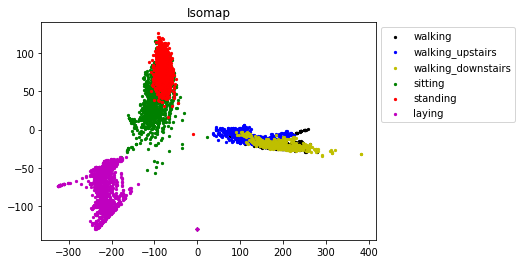

In [221]:
plt.title("Isomap")
plot_embedding(embed_iso)

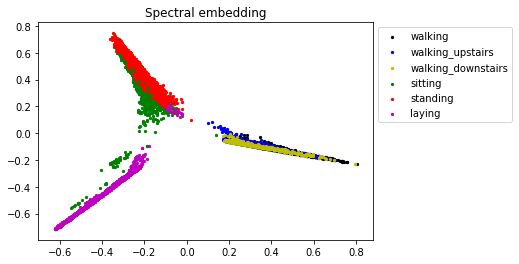

In [222]:
plt.title("Spectral embedding")
plot_embedding(embed_sp)

- t-SNE, according to [this](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b), should have the data's dimensions first reduced with PCA (to ~50) if it is very large:

In [223]:
pca = sklearn.decomposition.PCA(n_components=50)
train_X_pca = pca.fit_transform(train_X)
print("Variance explained: {0:.1f}%".format(
    pca.explained_variance_ratio_.sum() * 100))

Variance explained: 88.9%


In [224]:
# t-SNE is O(N^2) in number of samples, so sample down:
idxs_reduced = np.random.choice(train_X_pca.shape[0], 3000)
train_X_pca_reduced = train_X_pca[idxs_reduced]
train_y_reduced = train_y[idxs_reduced]

In [225]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=50)
embed_tsne = tsne.fit_transform(train_X_pca_reduced)

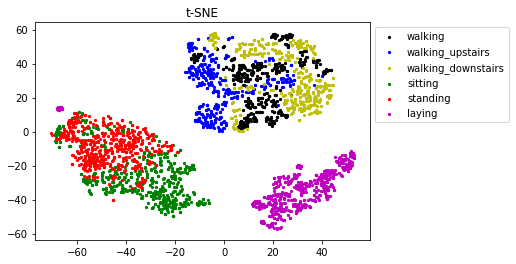

In [226]:
plt.title("t-SNE")
plot_embedding(embed_tsne, train_y_reduced)

- LLE and MDS were run too but did not produce much of interest
- The plot above with t-SNE seemed relatively stable to hyperparameter adjustment.  Playing with perplexity shifted some clusters around and spaced them out more, but did not seem to discriminate things any better.
- All three plots here are showing some similarities: Laying is clearly separated, and two other clusters clearly form, one with standing/sitting and one with the three kinds of walking. In t-SNE at least, sanding/sitting seems to partially separate out, while walking looks more mixed.
- This makes a bit of sense: All types of walking are fairly distinct (especially as far as an accelerometer cares) from the other activities, but less so from each other, and likewise for sitting/standing.

# Tensorflow Dabbling

In [231]:
import tensorflow as tf
from collections import namedtuple

import data_preprocessing

In [232]:
# Ignore all the code above and load with training/validation split:
train_X_orig, train_y_orig, test_X, test_y = data_preprocessing.read_raw_data()
data_preprocessing.standardize(train_X_orig, test_X)
train_X, valid_X, train_y, valid_y = data_preprocessing.split(
    train_X_orig, train_y_orig)

## Logistic Regression

### "Old" way, before writing an Estimator:

In [123]:
class LogisticRegressionGraph(object):
    
    def __init__(self, n_features, n_labels, lambda_=1e-3, scope="lr"):
        """Create a TensorFlow graph for multinomial logistic regression
        (in this case, softmax regression).  Specify the number of feature
        dimensions ('n_features') and number of labels to classify over
        ('n_labels').  Optional 'lambda' controls the strength of weight
        decay for regularization.
        """
        # Loosely based on:
        # http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression
        with tf.variable_scope(scope):
            # Data:
            self.example = tf.placeholder(tf.float32, [None, n_features])
            # Note that labels need to be one-hot encoded:
            self.label = tf.placeholder(tf.float32, [None, n_labels])
            # Model:
            self.weights = tf.get_variable("weights", [n_features, n_labels])
            self.bias = tf.get_variable("bias", [n_labels])
            # Unnormalized output (logits?):
            logits = tf.matmul(self.example, self.weights) + self.bias
            # 'softmax' is unnecessary here just for argmax (sigmoid would be
            # equivalent), but it doesn't make much difference:
            sm = tf.nn.softmax(logits)
            # TODO: Actually, are either of those necessary? Could I just use argmax on logits directly?
            self.predict_node = tf.argmax(sm, axis=1)
            # Cost function consists of cross-entropy, plus weight decay for
            # regularization:
            xe = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.label)
            decay = tf.reduce_sum(self.weights**2)
            self.loss = xe + lambda_ * decay / 2

    def predict(self, session, X):
        return session.run(self.predict_node, {self.example: X})

In [125]:
train_y_bin = sklearn.preprocessing.label_binarize(train_y, classes=range(1,7))

In [611]:
tf.reset_default_graph()
lr = LogisticRegressionGraph(train_X.shape[1], 6, 0) # 1e-3)
learning_rate = 0.0001
with tf.Session() as session:
    init = tf.global_variables_initializer()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train = optimizer.minimize(lr.loss)
    session.run(init)
    max_iters = 100
    #max_iters=10
    for i in range(max_iters):
        session.run(train, {lr.example: train_X, lr.label: train_y_bin})
        # Evaluate accuracy:
        if (i > 0 and i % 5 == 0) or (i == max_iters - 1):
            train_y_predict = lr.predict(session, train_X)
            valid_y_predict = lr.predict(session, valid_X)
            train_acc = sklearn.metrics.accuracy_score(train_y, train_y_predict + 1)
            valid_acc = sklearn.metrics.accuracy_score(valid_y, valid_y_predict + 1)
            print("Iter {0}/{1}, training/validation accuracy: {2:.3f}%, {3:.3f}%".format(
                i, max_iters, 100*train_acc, 100*valid_acc))

Iter 5/100, training/validation accuracy: 66.902%, 67.084%
Iter 10/100, training/validation accuracy: 86.598%, 86.453%
Iter 15/100, training/validation accuracy: 93.671%, 92.873%
Iter 20/100, training/validation accuracy: 93.779%, 93.580%
Iter 25/100, training/validation accuracy: 88.720%, 87.704%
Iter 30/100, training/validation accuracy: 95.684%, 95.484%
Iter 35/100, training/validation accuracy: 96.264%, 95.811%
Iter 40/100, training/validation accuracy: 95.720%, 95.539%
Iter 45/100, training/validation accuracy: 87.559%, 86.616%
Iter 50/100, training/validation accuracy: 96.808%, 96.083%
Iter 55/100, training/validation accuracy: 97.098%, 96.464%
Iter 60/100, training/validation accuracy: 97.443%, 96.736%
Iter 65/100, training/validation accuracy: 97.642%, 96.572%
Iter 70/100, training/validation accuracy: 97.044%, 96.246%
Iter 75/100, training/validation accuracy: 88.049%, 86.616%
Iter 80/100, training/validation accuracy: 97.370%, 96.572%
Iter 85/100, training/validation accuracy

### Implemented with Estimator and model function:

In [594]:
def lr_model_fn(features, labels, mode, params):
    # Model:
    weights = tf.get_variable("weights", [params["n_features"], params["n_classes"]], dtype=tf.float64)
    bias = tf.get_variable("bias", [params["n_classes"]], dtype=tf.float64)
    # Unnormalized output (logits?):
    logits = tf.matmul(features["x"], weights) + bias
    sm = tf.nn.softmax(logits)
    # TODO: Actually, are either of those necessary? Could I just use argmax on logits directly?
    predictions = tf.argmax(sm, axis=1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode, predictions={"activity": predictions})
    else:
        # Cost function consists of cross-entropy, plus weight decay for
        # regularization:
        onehot_labels = tf.one_hot(labels, params["n_classes"])
        decay = tf.reduce_sum(weights**2)
        xe = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
        loss = xe + params["lambda"] * decay / 2

        eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions)
        }
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=params["learning_rate"])
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=eval_metric_ops)

In [612]:
lr = tf.estimator.Estimator(
    model_fn=lr_model_fn,
    params={"learning_rate": 0.02, "n_classes": 6, "n_features": train_X.shape[1], "lambda": 0.02},
)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_X.values},
    y=train_y.values - 1,
    num_epochs=80,
    shuffle=False)
lr.train(input_fn=train_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /run/user/1000/tmpfa7_qcp6/model.ckpt.
INFO:tensorflow:step = 1, loss = 2.55884827552
INFO:tensorflow:global_step/sec: 324.955
INFO:tensorflow:step = 101, loss = 0.375474950181 (0.309 sec)
INFO:tensorflow:global_step/sec: 313.432
INFO:tensorflow:step = 201, loss = 0.275011441737 (0.319 sec)
INFO:tensorflow:global_step/sec: 316.685
INFO:tensorflow:step = 301, loss = 0.268908713994 (0.316 sec)
INFO:tensorflow:global_step/sec: 330.61
INFO:tensorflow:step = 401, loss = 0.194013482095 (0.302 sec)
INFO:tensorflow:global_step/sec: 334.69
INFO:tensorflow:step = 501, loss = 0.216757939291 (0.299 sec)
INFO:tensorflow:global_step/sec: 317.207
INFO:tensorflow:step = 601, loss = 0.216730147334 (0.315 sec)
INFO:tensorflow:global_step/sec: 311.37
INFO:tensorflow:step = 701, loss = 0.163677867364 (0.321 sec)
INFO:tensorflow:global_step/sec: 32

In [613]:
# Score accuracy
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": valid_X.values},
    y=valid_y.values - 1,
    num_epochs=1,
    shuffle=False)

ev = lr.evaluate(input_fn=test_input_fn)
print("Loss: %s" % ev["loss"])
print("Validation accuracy: %s" % ev["accuracy"])

INFO:tensorflow:Starting evaluation at 2017-11-22-18:18:16
INFO:tensorflow:Restoring parameters from /run/user/1000/tmpfa7_qcp6/model.ckpt-3447
INFO:tensorflow:Finished evaluation at 2017-11-22-18:18:16
INFO:tensorflow:Saving dict for global step 3447: accuracy = 0.974973, global_step = 3447, loss = 0.134243
Loss: 0.134243
Validation accuracy: 0.974973


In [623]:
valid_y_predict = np.array([i["activity"] for i in lr.predict(test_input_fn)])

# Confusion matrix (on validation set):
conf = sklearn.metrics.confusion_matrix(valid_y, valid_y_predict + 1)
conf = pd.DataFrame(conf, columns=label_list, index=label_list)
conf

INFO:tensorflow:Restoring parameters from /run/user/1000/tmpfa7_qcp6/model.ckpt-3447


,walking,walking_upstairs,walking_downstairs,sitting,standing,laying
walking,306,0,0,0,0,0
walking_upstairs,6,261,1,0,0,0
walking_downstairs,2,0,245,0,0,0
sitting,0,0,0,307,15,0
standing,0,0,0,22,321,0
laying,0,0,0,0,0,352


- Note that the confusion matrix here shows a shadow of what the manifold learning plots above (especially t-SNE) showed.  Most mistakes are confusion between sitting/standing, or walking types.

## Two-Layer ANN

### "Old" way, before writing an Estimator:

In [496]:
class ANNGraph(object):
    
    def __init__(self, n_features, n_labels, hidden_units=200, scope="nn"):
        """Create a TensorFlow graph for a two-layer neural net.
        Specify the number of feature dimensions ('n_features') and number
        of labels to classify over ('n_labels').  Optional 'hidden'
        controls the number of units in the hidden layer.
        """
        with tf.variable_scope(scope):
            # Data:
            self.example = tf.placeholder(tf.float32, [None, n_features])
            self.label = tf.placeholder(tf.float32, [None, n_labels])
            # Model:
            hidden = tf.layers.dense(self.example, hidden_units, activation=tf.nn.relu)
            logits = tf.layers.dense(hidden, n_labels)
            # If we need class probabilities:
            #prob = tf.nn.softmax(self.logits)
            # Prediction is just argmax
            self.predict_node = tf.argmax(logits, axis=1)
            # Cost function:
            self.loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.label)

    # TODO: Clarify differing data formats
    def predict(self, session, X):
        """Predict given a tensor of inputs."""
        return session.run(self.predict_node, {self.example: X})

In [283]:
tf.reset_default_graph()
ann = ANNGraph(train_X.shape[1], 6, 200)
# N.B. Higher learning rates appear to rapidly cause instability,
# leading to NaNs in softmax. Not sure if that's normal or not;
# is it my activation functions?
learning_rate = 3e-5
with tf.Session() as session:
    init = tf.global_variables_initializer()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train = optimizer.minimize(ann.loss)
    session.run(init)
    max_iters = 3000
    for i in range(max_iters):
        session.run(train, {ann.example: train_X, ann.label: train_y_bin})
        # Evaluate accuracy:
        if (i > 0 and i % 100 == 0) or (i == max_iters - 1):
            train_y_predict = ann.predict(session, train_X)
            valid_y_predict = ann.predict(session, valid_X)
            train_acc = sklearn.metrics.accuracy_score(train_y, train_y_predict + 1)
            valid_acc = sklearn.metrics.accuracy_score(valid_y, valid_y_predict + 1)
            print("Iter {0}/{1}, training/validation accuracy: {2:.3f}%, {3:.3f}%".format(
                i, max_iters, 100*train_acc, 100*valid_acc))

Iter 100/3000, training/validation accuracy: 97.933%, 96.627%
Iter 200/3000, training/validation accuracy: 98.404%, 97.171%
Iter 300/3000, training/validation accuracy: 99.148%, 97.878%
Iter 400/3000, training/validation accuracy: 99.492%, 98.041%
Iter 500/3000, training/validation accuracy: 99.619%, 98.150%
Iter 600/3000, training/validation accuracy: 99.873%, 98.368%
Iter 700/3000, training/validation accuracy: 99.946%, 98.422%
Iter 800/3000, training/validation accuracy: 99.982%, 98.477%
Iter 900/3000, training/validation accuracy: 99.982%, 98.531%
Iter 1000/3000, training/validation accuracy: 100.000%, 98.531%
Iter 1100/3000, training/validation accuracy: 100.000%, 98.585%
Iter 1200/3000, training/validation accuracy: 100.000%, 98.640%
Iter 1300/3000, training/validation accuracy: 100.000%, 98.694%
Iter 1400/3000, training/validation accuracy: 100.000%, 98.694%
Iter 1500/3000, training/validation accuracy: 100.000%, 98.749%
Iter 1600/3000, training/validation accuracy: 100.000%, 98

### Implemented with Estimator and model function:

In [608]:
def ann_model_fn(features, labels, mode, params):
    # Hidden layer:
    hidden = tf.layers.dense(features["x"], params["hidden_units"], activation=tf.nn.relu)
    # Output layer:
    logits = tf.layers.dense(hidden, params["n_classes"])
    # If we need class probabilities:
    #prob = tf.nn.softmax(self.logits)
    predictions = tf.argmax(logits, axis=1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode, predictions={"activity": predictions})
    else:
        #loss = tf.nn.softmax_cross_entropy_with_logits(
        #    onehot_labels=onehot_labels, logits=logits)
        onehot_labels = tf.one_hot(labels, params["n_classes"])
        loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
        eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions)
        }
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=params["learning_rate"])
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=eval_metric_ops)

In [618]:
nn = tf.estimator.Estimator(
    model_fn=ann_model_fn,
    params={"learning_rate": 0.01, "n_classes": 6, "hidden_units": 200},
)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_X.values},
    y=train_y.values - 1,
    num_epochs=100,
    shuffle=False)
nn.train(input_fn=train_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /run/user/1000/tmpthr8mvlq/model.ckpt.
INFO:tensorflow:step = 1, loss = 1.81422424316
INFO:tensorflow:global_step/sec: 117.688
INFO:tensorflow:step = 101, loss = 0.280669689178 (0.854 sec)
INFO:tensorflow:global_step/sec: 119.169
INFO:tensorflow:step = 201, loss = 0.21341881156 (0.836 sec)
INFO:tensorflow:global_step/sec: 119.72
INFO:tensorflow:step = 301, loss = 0.173136502504 (0.835 sec)
INFO:tensorflow:global_step/sec: 116.8
INFO:tensorflow:step = 401, loss = 0.107881963253 (0.856 sec)
INFO:tensorflow:global_step/sec: 120.939
INFO:tensorflow:step = 501, loss = 0.117544911802 (0.827 sec)
INFO:tensorflow:global_step/sec: 118.326
INFO:tensorflow:step = 601, loss = 0.129450589418 (0.845 sec)
INFO:tensorflow:global_step/sec: 119.202
INFO:tensorflow:step = 701, loss = 0.0869608074427 (0.839 sec)
INFO:tensorflow:global_step/sec: 12

In [619]:
# Score accuracy
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": valid_X.values},
    y=valid_y.values - 1,
    num_epochs=1,
    shuffle=False)

ev = nn.evaluate(input_fn=test_input_fn)
print("Loss: %s" % ev["loss"])
print("Validation accuracy: %s" % ev["accuracy"])

INFO:tensorflow:Starting evaluation at 2017-11-22-18:22:01
INFO:tensorflow:Restoring parameters from /run/user/1000/tmpthr8mvlq/model.ckpt-4308
INFO:tensorflow:Finished evaluation at 2017-11-22-18:22:02
INFO:tensorflow:Saving dict for global step 4308: accuracy = 0.979325, global_step = 4308, loss = 0.0514431
Loss: 0.0514431
Validation accuracy: 0.979325


In [621]:
valid_y_predict = np.array([i["activity"] for i in nn.predict(test_input_fn)])

# Confusion matrix (on validation set):
conf = sklearn.metrics.confusion_matrix(valid_y, valid_y_predict + 1)
conf = pd.DataFrame(conf, columns=label_list, index=label_list)
conf

INFO:tensorflow:Restoring parameters from /run/user/1000/tmpthr8mvlq/model.ckpt-4308


,walking,walking_upstairs,walking_downstairs,sitting,standing,laying
walking,305,0,1,0,0,0
walking_upstairs,6,262,0,0,0,0
walking_downstairs,2,0,245,0,0,0
sitting,0,0,0,310,12,0
standing,0,0,0,17,326,0
laying,0,0,0,0,0,352


- Note (in the pre-Estimator version) that validation accuracy continues to improve even when training accuracy is at 100%.  The loss function isn't based on this accuracy, but on the softmax probabilities. As far as I understand it: While a given instance will be labeled as correct if it assigns any probability > 0.5 to the correct label (and accuracy is based on this), training can continue to push these probabilities to be higher and form a sharper and sharper boundary between the other labels - and this might be reflected in better generalization.
- Errors are of the same sort as logistic regression.

## kNN

In [500]:
class KNearestNeighborGraph(object):
    
    def __init__(self, k, X, y, scope="knn"):
        """Create a TensorFlow graph for a k nearest neighbor classifier.
        This requires no training, but it does require that all of the data
        be supplied here in the constructor. Prediction does not do any
        weighting; the nearest k neighbors simply vote on a label.
        
        Arguments:
        k -- Number of nearest neighbors to use
        X -- Input data (should be a NumPy array)
        y -- Input labels (must have same length as X)
        """
        with tf.variable_scope(scope):
            self.example = tf.placeholder(tf.float32, [X.shape[1]])
            # All data & labels must be stored:
            self.y = tf.convert_to_tensor(y)
            self.X = tf.convert_to_tensor(X, dtype=np.float32)
            # Everything is based on squared Euclidean distance
            # between the input point, and every data point in X:
            dist2 = tf.reduce_sum((self.X - self.example)**2, axis=1)
            if k == 1:
                # k=1 requires no voting, just label of min-distance point:
                self.predict_node = tf.gather(self.y, tf.argmin(dist2, axis=0))
            else:
                # Otherwise, for each input row, get indices of the k
                # nearest neighbors:
                _, predict_idxs = tf.nn.top_k(-dist2, k=k)
                # (Note negation of dist2 - top_k does *descending* sort.)
                # And respective k labels of those k indices:
                self.predict_y = tf.gather(self.y, predict_idxs)
                # Tally them up:
                ys, _, num_y = tf.unique_with_counts(self.predict_y)
                # Find most common one:
                self.predict_node = tf.gather(ys, tf.argmax(num_y))
        # TODO: Make tie-breaking behavior more helpful. In the event of a tie
        # of distance, guess argmin and top_k likely pick the sample with the
        # lower index, which would bias towards a specific ordering of the data
        # (which should be irrelevant).  In the event of a tie in the voting for
        # labels, argmax will likewise pick the label that appears first, which
        # may bias either towards the lower-numbered label or the ordering of
        # the data (likewise, both irrelevant).
        # TODO also: This right now only works with a single input in
        # self.example, which probably slows things down.

    def predict(self, session, X_in):
        """Predict given a *single* input point."""
        return session.run(self.predict_node, {self.example: X_in})

In [502]:
tf.reset_default_graph()
knn = KNearestNeighborGraph(1, train_X.values, train_y.values)
import sys
with tf.Session() as session:
    init = tf.global_variables_initializer()
    session.run(init)
    # Evaluate accuracy:
    train_y_predict = np.zeros((train_X.shape[0]))
    for i in range(train_X.shape[0]):
        if (i % 100 == 0):
            sys.stdout.write(".")
            sys.stdout.flush()
        train_y_predict[i] = knn.predict(session, train_X.iloc[i, :])
    valid_y_predict = np.zeros((valid_X.shape[0]))
    print()
    for i in range(valid_X.shape[0]):
        if (i % 100 == 0):
            sys.stdout.write(".")
            sys.stdout.flush()
        valid_y_predict[i] = knn.predict(session, valid_X.iloc[i, :])
    print()
    #train_y_predict = knn.predict(session, train_X)
    #valid_y_predict = knn.predict(session, valid_X)
    train_acc = sklearn.metrics.accuracy_score(train_y, train_y_predict)
    valid_acc = sklearn.metrics.accuracy_score(valid_y, valid_y_predict)
    print("Training/validation accuracy: {0:.3f}%, {1:.3f}%".format(
        100*train_acc, 100*valid_acc))

........................................................
...................
Training/validation accuracy: 100.000%, 98.313%


In [504]:
# Confusion matrix (on validation set):
conf = sklearn.metrics.confusion_matrix(valid_y, valid_y_predict)
conf = pd.DataFrame(conf, columns=label_list, index=label_list)
conf

,walking,walking_upstairs,walking_downstairs,sitting,standing,laying
walking,305,0,1,0,0,0
walking_upstairs,6,262,0,0,0,0
walking_downstairs,5,1,241,0,0,0
sitting,0,0,0,308,14,0
standing,0,0,0,4,339,0
laying,0,0,0,0,0,352


- Tests with higher values of `k` aren't shown here, but they don't seem to help validation error at all.
- Interestingly, despite the data having nearly 1000 dimensions and no feature selection being done, the Curse of Dimensionality seems to matter none in this instance.
- Errors are of the same sort as other classifiers. A little more confusion is seen in the walking types here, and a little less between sitting/standing. Laying is again discriminated perfectly.